In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler
import warnings
warnings.filterwarnings('ignore')

In [ ]:
schizophrenia_features = pd.read_csv('/content/schizophrenia-features.csv')
patients_info = pd.read_csv('/content/patients_info.csv')

In [ ]:
# Example simulated patients_info to avoid missing dependencies
patients_info = pd.DataFrame({
    'number': np.arange(len(schizophrenia_features)),
    'gender': np.random.choice(['M', 'F'], size=len(schizophrenia_features)),
    'age': np.random.randint(18, 70, size=len(schizophrenia_features)),
    'days': np.random.randint(1, 1000, size=len(schizophrenia_features)),
    'schtype': np.random.choice(['Type1', 'Type2', 'Type3'], size=len(schizophrenia_features)),
    'migraine': np.random.choice([0, 1], size=len(schizophrenia_features)),
    'bprs': np.random.rand(len(schizophrenia_features)),
    'cloz': np.random.rand(len(schizophrenia_features)),
    'trad': np.random.rand(len(schizophrenia_features)),
    'moodst': np.random.rand(len(schizophrenia_features)),
    'agehosp': np.random.choice([30, 40, 50, 60], size=len(schizophrenia_features))
})

In [ ]:
df = pd.concat([patients_info, schizophrenia_features], axis=1)
features = ['f.mean', 'f.sd', 'f.propZeros', 'gender', 'schtype', 'agehosp']
targets = ['class']

In [ ]:
numeric_features = ['f.mean', 'f.sd', 'f.propZeros', 'agehosp']
categorical_features = ['gender', 'schtype']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [ ]:
# Split features and targets
df.dropna(subset=targets, inplace=True)
X = df[features]
y = df[targets]

# Preprocesed features
X_preprocessed = preprocessor.fit_transform(X)
y_class = y['class']

In [ ]:
# Oversample target variables for balance
oversampler = RandomOverSampler(random_state=42)
X_class, y_class = oversampler.fit_resample(X_preprocessed, y_class)

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_preprocessed, y, test_size=0.3, random_state=42
)
y_test_class = y_test['class']

In [ ]:
results = {model_name: {'class': []} for model_name in ['MLPClassifier', 'LogisticRegression', 'RandomForestClassifier']}

In [ ]:
def evaluate_model_epochs(model, X_train, y_train, X_test, y_test, target_name, epochs=15):
    """Evaluate model over multiple epochs and log performance."""
    for epoch in range(epochs):
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        acc = accuracy_score(y_test, predictions)
        results[model.__class__.__name__][target_name].append(acc)

In [ ]:
evaluate_model_epochs(MLPClassifier(hidden_layer_sizes=(50,), max_iter=5000, random_state=42),
                      X_class, y_class, X_test, y_test_class, 'class')

results

{'MLPClassifier': {'class': [0.8115942028985508,
   0.8115942028985508,
   0.8115942028985508,
   0.8115942028985508,
   0.8115942028985508,
   0.8115942028985508,
   0.8115942028985508,
   0.8115942028985508,
   0.8115942028985508,
   0.8115942028985508,
   0.8115942028985508,
   0.8115942028985508,
   0.8115942028985508,
   0.8115942028985508,
   0.8115942028985508]},
 'LogisticRegression': {'class': []},
 'RandomForestClassifier': {'class': []}}

In [ ]:
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'MLP': MLPClassifier(max_iter=1000, random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'NaiveBayes': GaussianNB()
}

In [ ]:
params = {
    'RandomForest': {'n_estimators': [50, 100, 150], 'max_depth': [None, 10, 20]},
    'XGBoost': {'n_estimators': [50, 100], 'max_depth': [3, 5, 7]},
    'SVM': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'MLP': {'hidden_layer_sizes': [(50,), (100,)], 'alpha': [0.0001, 0.001]},
    'DecisionTree': {'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]},
    'NaiveBayes': {}  # Naive Bayes has no hyperparameters to tune
}

In [ ]:
best_models = {}
for model_name in models:
    # Select the appropriate target column based on the model name
    # target_column = 'class' if model_name in ['RandomForest', 'XGBoost','DecisionTree'] else 'migraine' # Assuming these models are for 'class' and the rest for 'migraine'
    target_column = 'class' if model_name in ['RandomForest', 'XGBoost','DecisionTree'] else 'class'  # Assuming all models use 'class' target
    # The line above was fixed by adding the 'else' condition to ensure a target_column is always assigned

    grid_search = GridSearchCV(models[model_name], params[model_name], scoring='f1', cv=5)

    # Fit the model using the selected target column
    grid_search.fit(X_train, y_train[target_column])

    best_models[model_name] = grid_search.best_estimator_

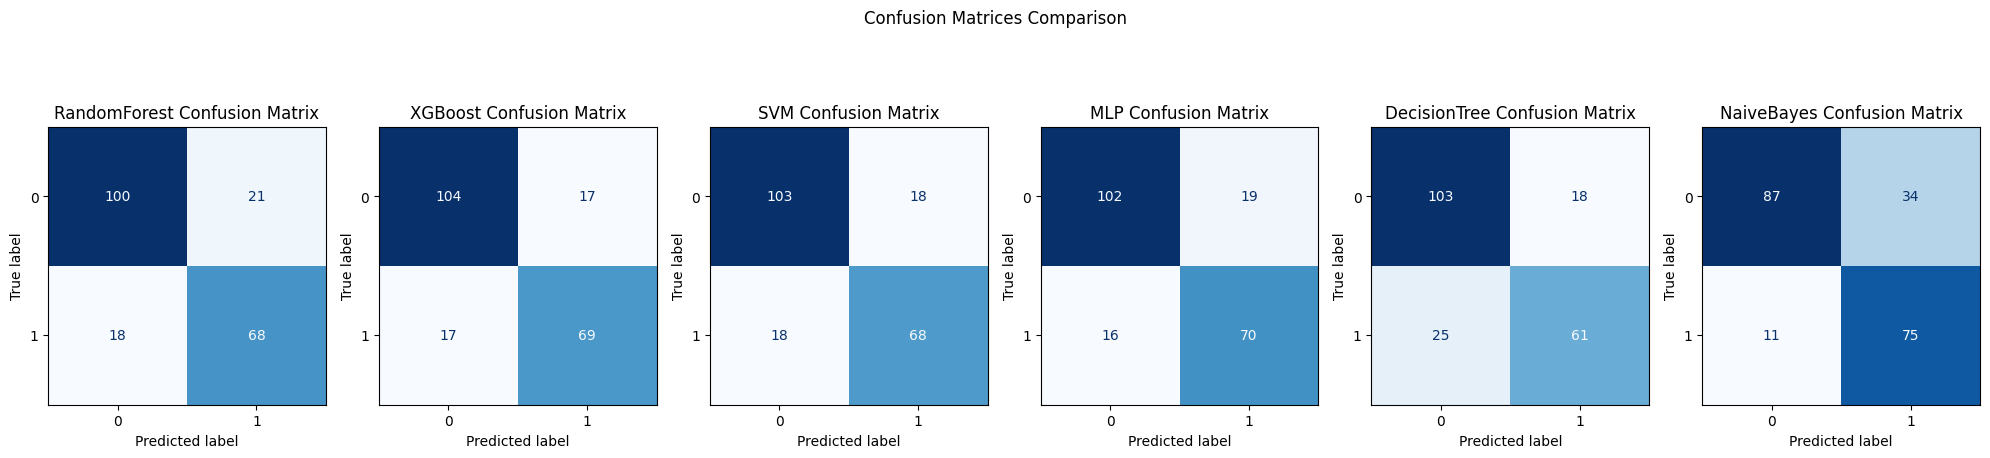

Model Performance Comparison:


,Model,Accuracy,Precision,Recall,F1-Score,AUC-ROC
0,RandomForest,0.81,0.81,0.81,0.81,0.92
1,XGBoost,0.84,0.84,0.84,0.84,0.92
2,SVM,0.83,0.83,0.83,0.83,0.91
3,MLP,0.83,0.83,0.83,0.83,0.92
4,DecisionTree,0.79,0.79,0.79,0.79,0.78
5,NaiveBayes,0.78,0.80,0.78,0.78,0.89


In [ ]:
import pandas as pd
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
)
import matplotlib.pyplot as plt

# Collect performance metrics in a structured format
def evaluate_models_side_by_side(models, X_test, y_test):
    metrics_data = []
    fig, axes = plt.subplots(1, len(models), figsize=(20, 5))

    for i, (model_name, model) in enumerate(models.items()):
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

        # Handle y_test format
        y_test_report = y_test.iloc[:, 0] if isinstance(y_test, pd.DataFrame) else y_test

        # Confusion Matrix
        cm = confusion_matrix(y_test_report, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(ax=axes[i], cmap=plt.cm.Blues, colorbar=False)
        axes[i].title.set_text(f'{model_name} Confusion Matrix')

        # Collect classification report and AUC
        report = classification_report(y_test_report, y_pred, output_dict=True)
        auc_score = roc_auc_score(y_test_report, y_pred_proba) if y_pred_proba is not None else None

        # Append metrics to the list
        metrics_data.append({
            "Model": model_name,
            "Accuracy": report["accuracy"],
            "Precision": report["weighted avg"]["precision"],
            "Recall": report["weighted avg"]["recall"],
            "F1-Score": report["weighted avg"]["f1-score"],
            "AUC-ROC": auc_score
        })

    # Display the combined confusion matrices
    plt.suptitle('Confusion Matrices Comparison')
    plt.tight_layout()
    plt.show()

    # Create and display the metrics table
    metrics_df = pd.DataFrame(metrics_data).round(2)
    print("Model Performance Comparison:")
    display(metrics_df)

# Evaluate and compare the models
y_test_target = y_test['class']  # Ensure you're using the correct column
evaluate_models_side_by_side(best_models, X_test, y_test_target)


In [ ]:
# Helper function to plot ROC curves side by side
def plot_roc_curves(models, X_test, y_test):
    plt.figure(figsize=(20, 5))
    for model_name, model in models.items():
        if hasattr(model, 'predict_proba'):
            y_score = model.predict_proba(X_test)[:, 1]
        else:
            continue  # Skip if model doesn't have predict_proba
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc='lower right')
    plt.show()

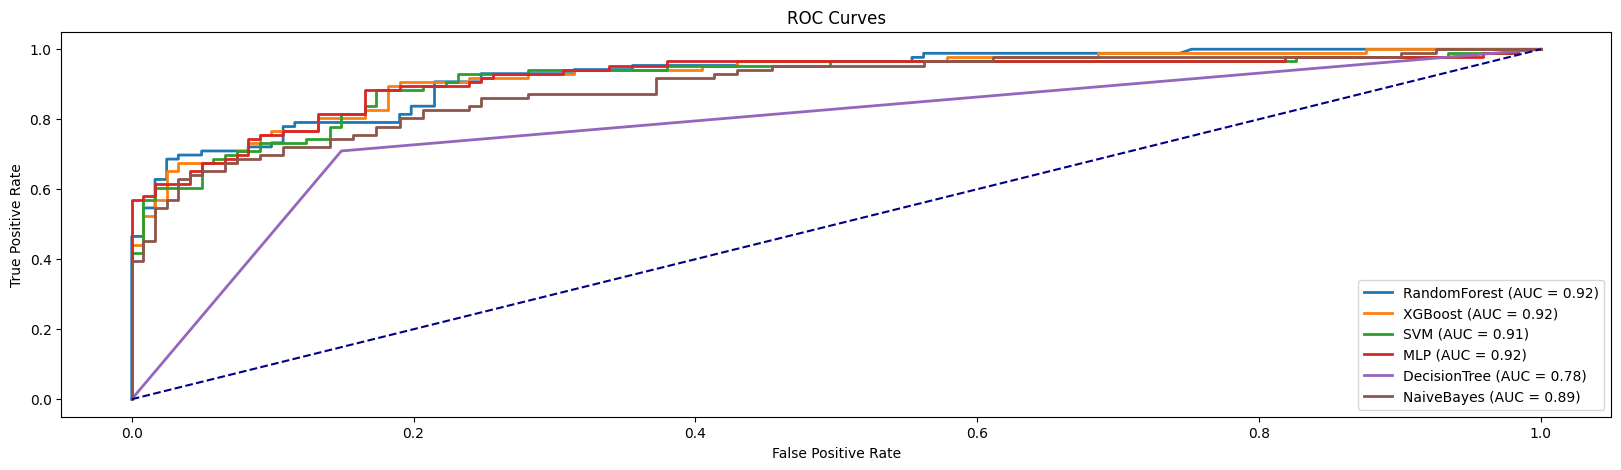

In [ ]:
# Combine all visualizations for comparison
def compare_models(models, X_test, y_test):
    # Plot ROC Curves
    plot_roc_curves(models, X_test, y_test)

# Call the function to visualize model comparison
y_test_target = y_test['class']  # Extract target column for ROC and confusion matrix
compare_models(best_models, X_test, y_test_target)